In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    r2_score, accuracy_score, classification_report, 
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
import os

FEATURES = [
    'MgFe', '[M/H]_mean_mass', '[M/H]_err_mass',
    'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
    'age_mean_mass', 'age_err_mass'
]

MODEL_PARAMS = {
    'max_depth': 22,
    'max_features': 0.793,
    'max_samples': 0.500,
    'min_samples_leaf': 1,
    'min_samples_split': 4,
    'n_estimators': 460,
    'random_state': 42
}

In [19]:
"""def evaluate_regression(df, n_splits=5):
    print(f"\nRunning {n_splits}-fold cross validation for regression...")
    
    X = df[FEATURES]
    y = df['DoR']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    
    scores = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        r2 = r2_score(y_test, y_pred)
        scores.append(r2)
        
        print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    print(f"\nMean R²: {np.mean(scores):.4f} (±{np.std(scores):.4f})")
    return scores"""

def evaluate_final_regression(df, test_size=0.2, seed=42):
    print("\nEvaluating final regression model...")
    
    X = df[FEATURES]
    y = df['DoR']
    
    # Split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions on test set
    y_test_pred = rf_model.predict(X_test_scaled)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Make predictions on all data
    X_all_scaled = scaler.transform(X)
    y_all_pred = rf_model.predict(X_all_scaled)
    all_r2 = r2_score(y, y_all_pred)
    
    # Plot test set predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y_test), min(y_test_pred))
    max_val = max(max(y_test), max(y_test_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('True DoR')
    plt.ylabel('Predicted DoR')
    plt.title(f'Test Set Results\nR² = {test_r2:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot all data predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_all_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(min(y), min(y_all_pred))
    max_val = max(max(y), max(y_all_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    
    plt.xlabel('True DoR')
    plt.ylabel('Predicted DoR')
    plt.title(f'All Data Results\nR² = {all_r2:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Test Set R²: {test_r2:.4f}")
    print(f"All Data R²: {all_r2:.4f}")
    
    return rf_model, scaler, test_r2, all_r2

In [20]:
def evaluate_classification(df, n_splits=5, split_threshold=0.6):
    """Run classification analysis with k-fold cross validation"""
    print(f"\nRunning {n_splits}-fold classification...")
    
    X = df[FEATURES]
    y = (df['DoR'] > split_threshold).astype(int)
    class_names = [f'DoR ≤ {split_threshold}', f'DoR > {split_threshold}']
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    clf = RandomForestClassifier(**MODEL_PARAMS)
    
    results = {
        'accuracies': [], 'confusion_matrices': [],
        'classification_reports': [], 'roc_aucs': [], 'feature_importance':[]
    }
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Prepare and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train and evaluate
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]
        
        # Store results
        results['accuracies'].append(accuracy_score(y_test, y_pred))
        results['confusion_matrices'].append(confusion_matrix(y_test, y_pred))
        results['classification_reports'].append(
            classification_report(y_test, y_pred, target_names=class_names)
        )
        results['feature_importance'].append(
            dict(zip(FEATURES, clf.feature_importances_))
        )
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        results['roc_aucs'].append(auc(fpr, tpr))
        
        print(f"\nFold {fold}/{n_splits}")
        print(results['classification_reports'][-1])
    
    # Plot average confusion matrix
    avg_cm = np.mean(results['confusion_matrices'], axis=0) / (0.2 * len(df)) * 100
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        avg_cm, annot=True, fmt='.1f', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title('Average Confusion Matrix Across All Folds')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    mean_importance = pd.DataFrame(results['feature_importance']).mean()
    plt.figure(figsize=(10, 6))
    mean_importance.sort_values().plot(kind='barh')
    plt.title('Mean Feature Importance Across All Folds')
    plt.xlabel('Mean Importance')
    plt.tight_layout()
    plt.show()
    
    return results

In [21]:
def export_dor_groups(df, output_path, small_boundary=0.4, large_boundary=0.55, csv_name='DoR_Groups.csv' ):
    """Export DoR groups to CSV"""
    os.makedirs(output_path, exist_ok=True)
    
    # Create SDSS identifiers
    sdss_ids = [
        f"spec-{int(plate):04d}-{int(mjd):05d}-{int(fiber):04d}.fits" 
        for plate, mjd, fiber in zip(df['plate'], df['mjd'], df['fiberid'])
    ]
    
    # Create labels
    labels = pd.Series(1, index=df.index)  # middle group
    labels[df['DoR'] <= small_boundary] = 0  # small group
    labels[df['DoR'] >= large_boundary] = 2  # large group
    
    # Save results
    results_df = pd.DataFrame({'SDSS_ID': sdss_ids, 'Cluster': labels})
    filename = os.path.join(output_path, csv_name)
    results_df.to_csv(filename, index=False)
    
    print(f"Saved DoR groups to {filename}")
    print("Group sizes:")
    print(f"DoR <= {small_boundary}: {sum(labels == 0)}")
    print(f"{small_boundary} < DoR < {large_boundary}: {sum(labels == 1)}")
    print(f"DoR >= {large_boundary}: {sum(labels == 2)}")



Evaluating final regression model...


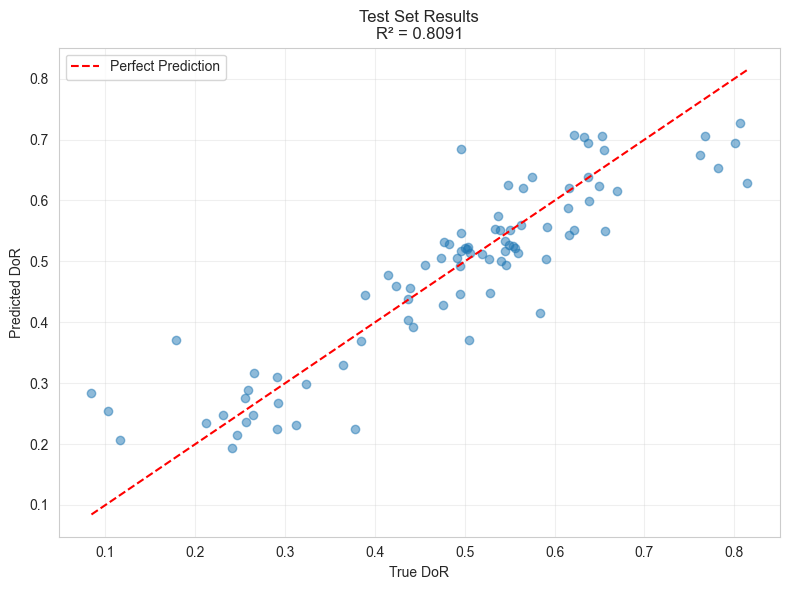

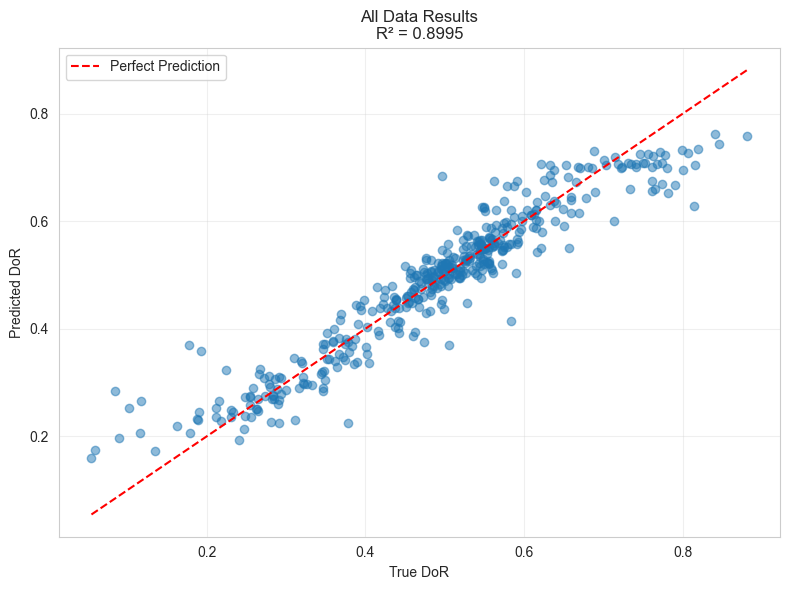

Test Set R²: 0.8091
All Data R²: 0.8995

Running 5-fold classification...

Fold 1/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.90      0.95      0.93        66
   DoR > 0.6       0.81      0.65      0.72        20

    accuracy                           0.88        86
   macro avg       0.86      0.80      0.82        86
weighted avg       0.88      0.88      0.88        86


Fold 2/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.96      0.99      0.97        72
   DoR > 0.6       0.92      0.79      0.85        14

    accuracy                           0.95        86
   macro avg       0.94      0.89      0.91        86
weighted avg       0.95      0.95      0.95        86


Fold 3/5
              precision    recall  f1-score   support

   DoR ≤ 0.6       0.97      0.93      0.95        69
   DoR > 0.6       0.75      0.88      0.81        17

    accuracy                           0.92        86
   macro avg       0.86 

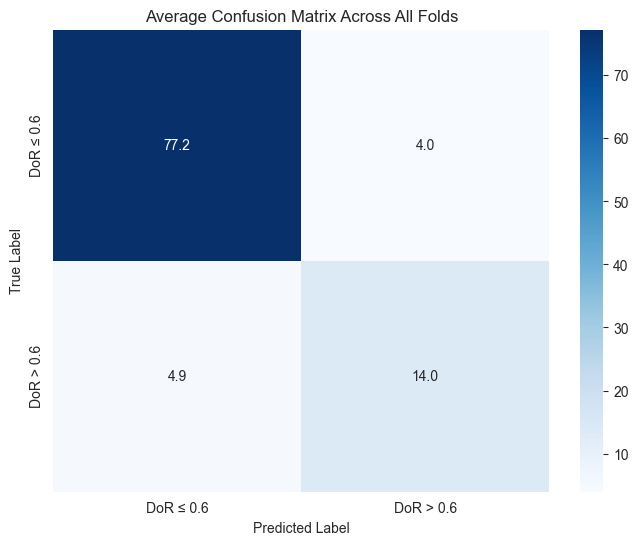

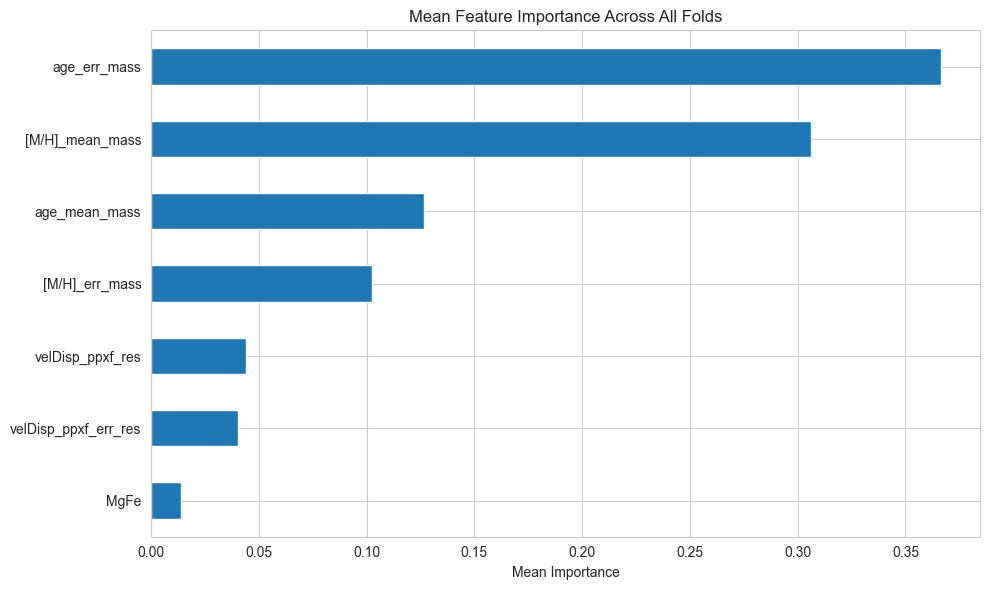

Saved DoR groups to ../data/cluster_results/regression_clusters.csv
Group sizes:
DoR <= 0.3: 56
0.3 < DoR < 0.6: 293
DoR >= 0.6: 81


In [22]:

filepath = '../data/E-INSPIRE_I_master_catalogue.csv'
output_path = '../data/cluster_results'
csv_name = 'regression_clusters.csv'

df = pd.read_csv(filepath)

# Run regression analysis
#reg_results = evaluate_regression(df, n_splits=5)
rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df)

# Run classification analysis
class_results = evaluate_classification(df, n_splits=5, split_threshold=0.6)

# Export groups
export_dor_groups(df,small_boundary=0.3, large_boundary=0.6, output_path=output_path, csv_name=csv_name)

Checking that seed isnt important

In [23]:
"""seeds = [0,1,2,3,4,5,6,7,8,9]
r2 = []
seeds = np.arange(100)
print(seeds)

for seed in seeds:
    print("SEED", seed)
    rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df, seed=seed)
    r2.append(test_r2)
    

print(np.mean(r2), np.std(r2))"""

'seeds = [0,1,2,3,4,5,6,7,8,9]\nr2 = []\nseeds = np.arange(100)\nprint(seeds)\n\nfor seed in seeds:\n    print("SEED", seed)\n    rf_model, scaler, test_r2, all_r2 = evaluate_final_regression(df, seed=seed)\n    r2.append(test_r2)\n    \n\nprint(np.mean(r2), np.std(r2))'

## Checking random stuff that might be interesting ML wise. 

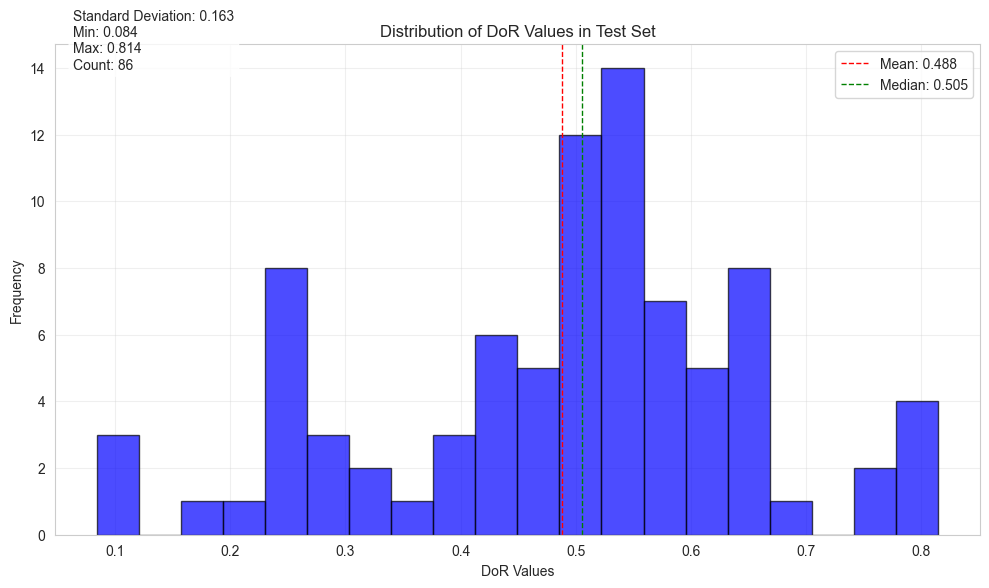

In [24]:
# Create histogram of DoR values in test set
def plot_dor_histogram(df, test_size=0.2, seed=42):
    # Extract features and target
    X = df[FEATURES]
    y = df['DoR']
    
    # Split the data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed
    )
    
    # Create histogram
    plt.figure(figsize=(10, 6))
    hist = plt.hist(y_test, bins=20, alpha=0.7, color='blue', edgecolor='black')
    
    # Add distribution statistics
    plt.axvline(y_test.mean(), color='red', linestyle='dashed', linewidth=1, 
                label=f'Mean: {y_test.mean():.3f}')
    plt.axvline(y_test.median(), color='green', linestyle='dashed', linewidth=1, 
                label=f'Median: {y_test.median():.3f}')
    
    # Add text with additional statistics
    stats_text = (f"Standard Deviation: {y_test.std():.3f}\n"
                  f"Min: {y_test.min():.3f}\n"
                  f"Max: {y_test.max():.3f}\n"
                  f"Count: {len(y_test)}")
    plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    # Formatting
    plt.xlabel('DoR Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of DoR Values in Test Set')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return y_test

# Usage example (you can uncomment this when ready to run)
test_dor_values = plot_dor_histogram(df, test_size=0.2, seed=42)

KeyError: 'values'

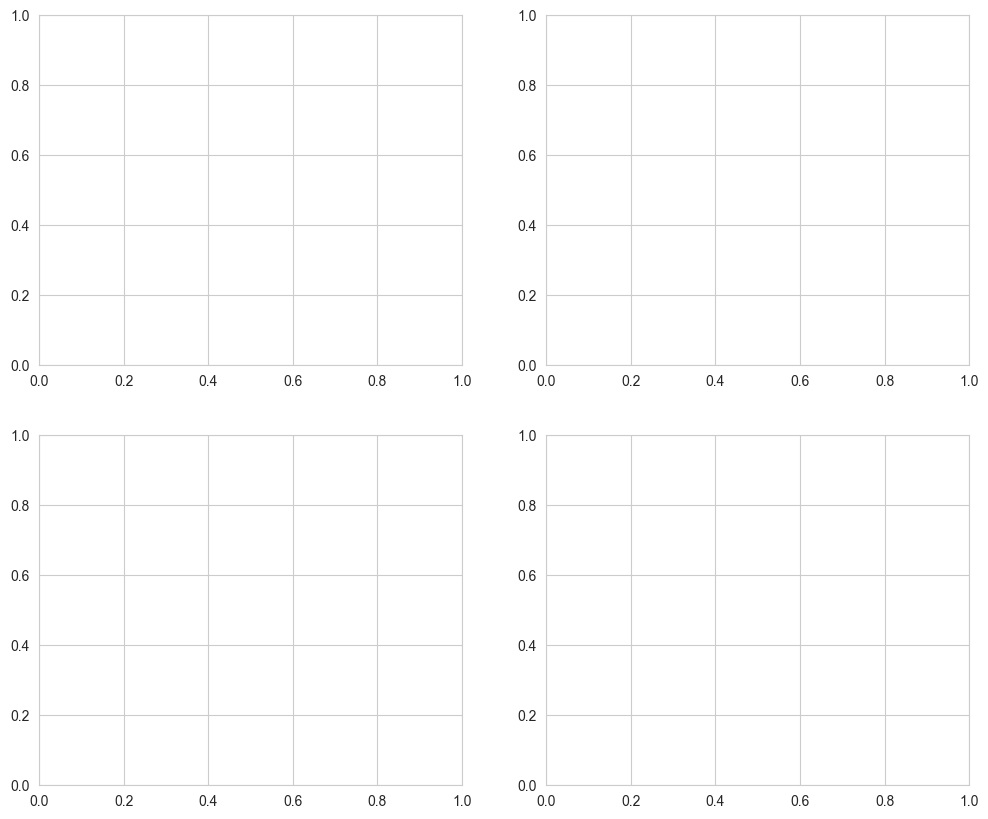

In [26]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt
X = df[FEATURES]
y = df['DoR']
# Assuming rf_model is your trained Random Forest model
# and X is your feature matrix
features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    pdp = partial_dependence(rf_model, X, [feature], kind='average')
    axes[i].plot(pdp["values"][0], pdp["average"][0])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial dependence')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegre

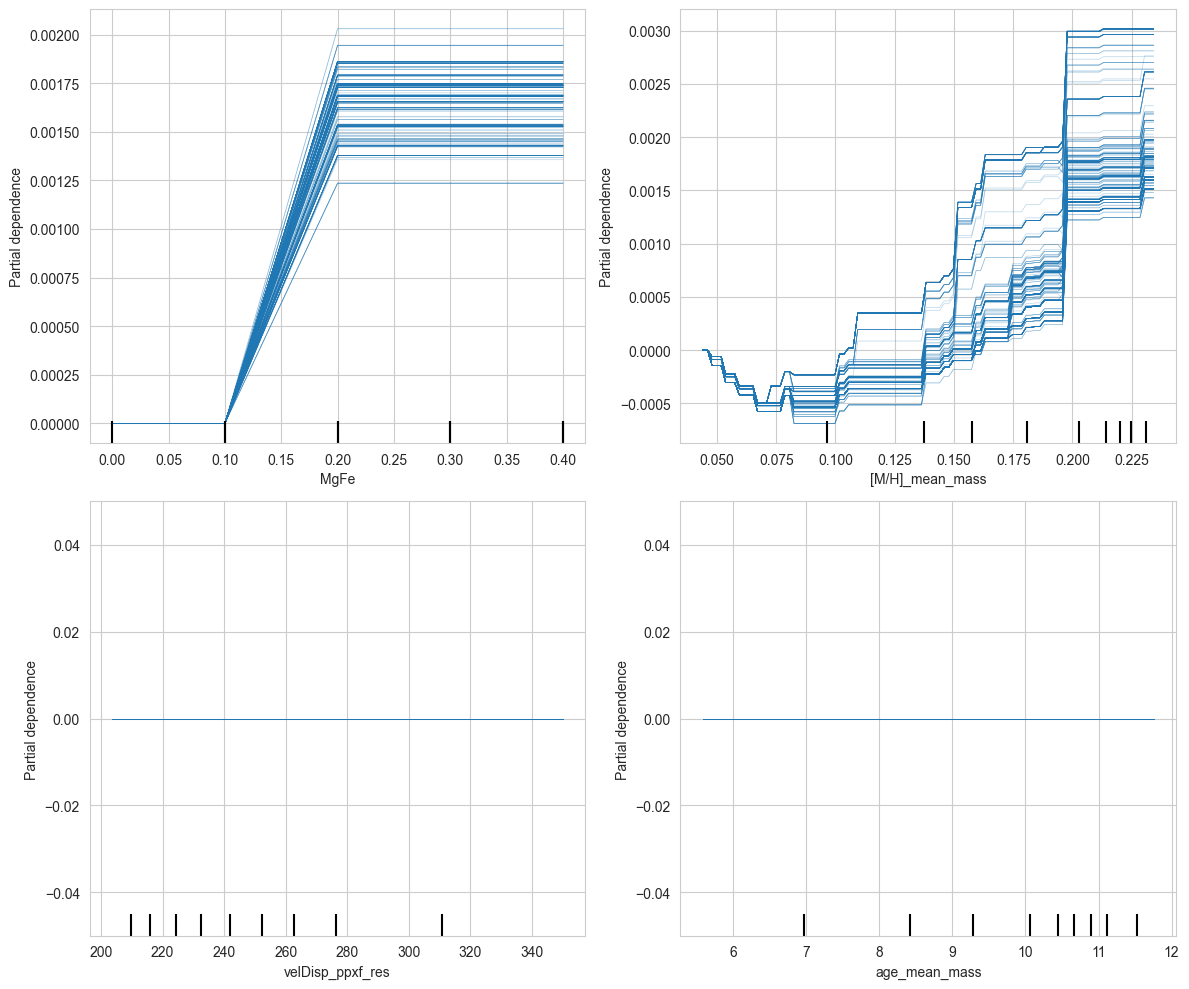

In [27]:
from sklearn.inspection import PartialDependenceDisplay

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        rf_model, X, [feature], 
        kind='individual', centered=True, 
        ax=axes[i], n_jobs=-1
    )
    axes[i].set_ylabel('Effect on DoR prediction')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

IndexError: list index out of range

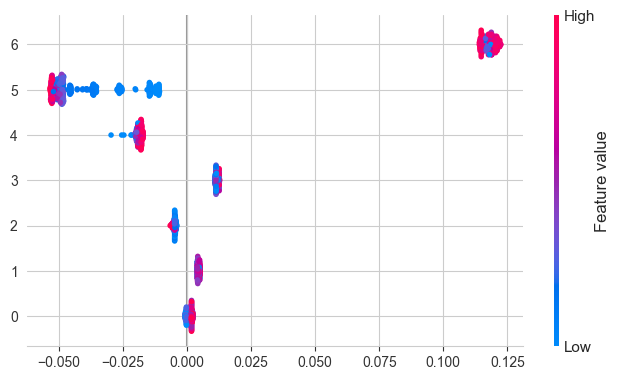

In [28]:
import shap

# Create a SHAP explainer for your random forest model
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# Summary plot showing feature importance and impact direction
shap.summary_plot(shap_values, X, feature_names=features)

# Detailed dependence plot for the most important feature
# (e.g., MgFe or velocity dispersion)
shap.dependence_plot("MgFe", shap_values, X, feature_names=features)

# Force plot for specific examples (e.g., a borderline relic)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], 
                feature_names=features)

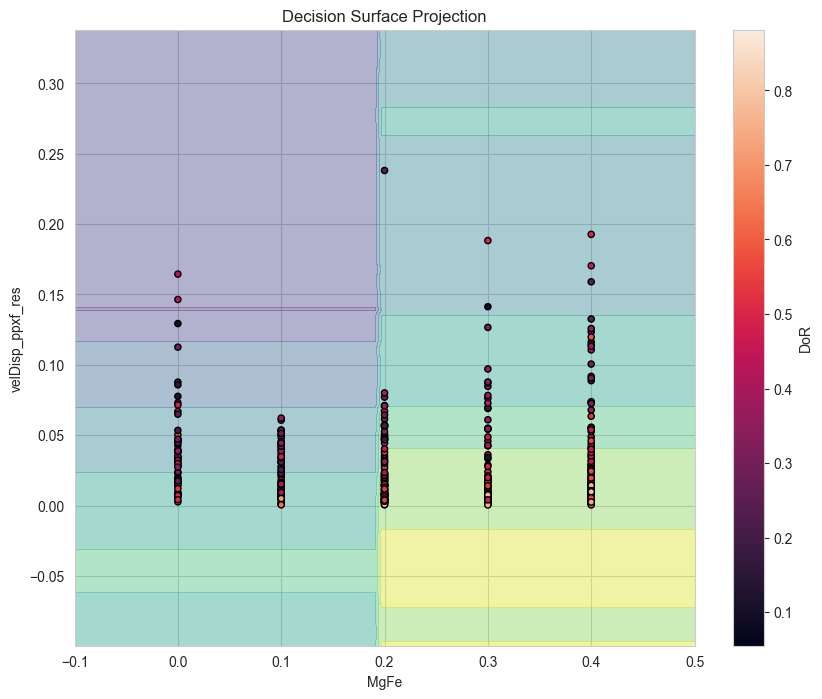

In [29]:
import numpy as np
from sklearn.inspection import DecisionBoundaryDisplay

# Select the two most important features
feature1, feature2 = 'MgFe', 'velDisp_ppxf_res'
indices = [features.index(feature1), features.index(feature2)]

# Create a meshgrid
x_min, x_max = X.iloc[:, indices[0]].min() - 0.1, X.iloc[:, indices[0]].max() + 0.1
y_min, y_max = X.iloc[:, indices[1]].min() - 0.1, X.iloc[:, indices[1]].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                      np.linspace(y_min, y_max, 100))

# For each point in the meshgrid, get the prediction
Z = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        # Create a point with mean values except for the two selected features
        X_point = X.mean().values.copy()
        X_point[indices[0]] = xx[i, j]
        X_point[indices[1]] = yy[i, j]
        # Predict
        Z[i, j] = rf_model.predict([X_point])[0]

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
plt.scatter(X.iloc[:, indices[0]], X.iloc[:, indices[1]], c=y, s=20, edgecolor='k')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.colorbar(label='DoR')
plt.title('Decision Surface Projection')
plt.show()

In [ ]:
from sklearn.tree import export_text

# Extract rules from a single tree in the forest
rules = export_text(rf_model.estimators_[0], feature_names=features)
print(rules)

# For a more comprehensive approach, you can analyze rules across multiple trees
def extract_paths(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = tree.tree_.feature
    value = tree.tree_.value
    
    def recurse(node, path, paths):
        if left[node] == -1:  # Leaf node
            paths.append((path, value[node][0][0]))
            return
        
        feature_name = feature_names[features[node]]
        threshold_val = threshold[node]
        
        # Left path - feature <= threshold
        path_left = path.copy()
        path_left.append(f"{feature_name} ≤ {threshold_val:.2f}")
        recurse(left[node], path_left, paths)
        
        # Right path - feature > threshold
        path_right = path.copy()
        path_right.append(f"{feature_name} > {threshold_val:.2f}")
        recurse(right[node], path_right, paths)
    
    paths = []
    recurse(0, [], paths)
    return paths

# Extract paths from a few representative trees
for i in range(3):
    tree_paths = extract_paths(rf_model.estimators_[i], features)
    # Sort paths by predicted value (descending)
    tree_paths.sort(key=lambda x: x[1], reverse=True)
    print(f"Tree {i} top paths for high DoR:")
    for path, value in tree_paths[:3]:
        if value > 0.5:  # Only show high DoR paths
            print(f"  Predicted DoR: {value:.3f}, Path: {' AND '.join(path)}")
    print()

In [ ]:
import itertools

# Get feature importance
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
top_features = [features[i] for i in sorted_idx[:4]]  # Top 4 features

# Find predictive power of pairs
for feature_pair in itertools.combinations(top_features, 2):
    # Create a model with just this pair
    indices = [features.index(feature_pair[0]), features.index(feature_pair[1])]
    X_pair = X.iloc[:, indices]
    pair_model = RandomForestRegressor(**MODEL_PARAMS)
    pair_model.fit(X_pair, y)
    score = pair_model.score(X_pair, y)
    print(f"Pair {feature_pair}: R² = {score:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Evaluate different DoR thresholds
thresholds = np.arange(0.2, 0.7, 0.05)
results = []

for threshold in thresholds:
    # Create binary labels using this threshold
    y_true_binary = (y > threshold).astype(int)
    y_pred_binary = (rf_model.predict(X) > threshold).astype(int)
    
    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_binary, y_pred_binary, average='binary')
    
    results.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Convert to DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

# Plot metrics vs threshold
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision')
plt.plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall')
plt.plot(results_df['threshold'], results_df['f1'], 'g-', label='F1 Score')
plt.xlabel('DoR Threshold')
plt.ylabel('Score')
plt.title('Classification Metrics vs DoR Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()